In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import csiborgtools
from h5py import File
from gc import collect

In [4]:
with File("/mnt/extraspace/rstiskalek/csiborg2/snapshot_099.hdf5", 'r') as f:
    # print(f["Header"].attrs["BoxSize"])
    mhigh = f["Header"].attrs["MassTable"][1]
    pos1 = f['PartType1']['Coordinates'][:]
    pos5 = f['PartType5']['Coordinates'][:]
    mass5 = f['PartType5']['Masses'][:]

mass1 = np.ones(len(pos1)) * mhigh * 1e10
mass5 *= 1e10



In [5]:
pos = np.concatenate((pos1, pos5), axis=0)
mass = np.concatenate((mass1, mass5), axis=0).astype(np.float32)

del pos1, pos5, mass1, mass5
collect()


80

In [6]:
import MAS_library as MASL


# density field parameters
grid    = 512 #the 3D field will have grid x grid x grid voxels
BoxSize = 677.7 #Mpc/h ; size of box
MAS     = 'PCS'  #mass-assigment scheme
verbose = True   #print information on progress

# define 3D density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)
# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose, W=mass)



Using PCS mass assignment scheme with weights
Time taken = 58.325 seconds



In [18]:
# np.save("delta_8600_PCS.npy", delta)
delta_new = np.load("delta_8600_PCS.npy")

delta_old = np.load("/mnt/extraspace/rstiskalek/CSiBORG/environment/density_PCS_08596_grid512.npy").T

In [19]:
delta_new /= np.mean(delta_new)
delta_new -= 1
delta_old /= np.mean(delta_old)
delta_old -= 1

# delta_new = np.log10(delta_new)
# delta_old = np.log10(delta_old)

In [32]:
imin = 256 - 50
imax = 256 + 50

delta_new_central = np.zeros_like(delta_new)
delta_new_central[imin:imax, imin:imax, imin:imax] = delta_new[imin:imax, imin:imax, imin:imax]

delta_old_central = np.zeros_like(delta_old)
delta_old_central[imin:imax, imin:imax, imin:imax] = delta_old[imin:imax, imin:imax, imin:imax]

In [33]:
# plt.figure()
# plt.imshow(delta_new_central[:, 256, :], origin='lower')

# plt.show()

In [34]:
knew, pknew = csiborgtools.field.power_spectrum(delta_new_central, 677.7, "PCS", threads=2)
kold, pkold = csiborgtools.field.power_spectrum(delta_old_central, 677.7, "PCS", threads=2)


Computing power spectrum of the field...
Time to complete loop = 8.08
Time taken = 14.80 seconds

Computing power spectrum of the field...
Time to complete loop = 8.02
Time taken = 14.54 seconds


In [35]:
import camb
from camb import model 

pars = camb.CAMBparams()
h = 0.705
pars.set_cosmology(H0=h*100, ombh2=0.04825 * h**2, omch2=(0.307 - 0.04825) * h**2)
pars.InitPower.set_params(ns=0.9611)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=40)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results = camb.get_results(pars)
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=50, npoints = 200)

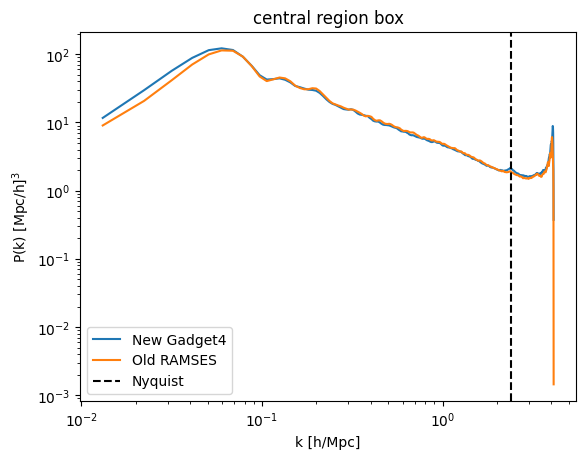

In [37]:
plt.figure()
plt.plot(knew, pknew, label="New Gadget4")
plt.plot(kold, pkold, label="Old RAMSES")

# m = (kh_nonlin > knew.min()) & (kh_nonlin < knew.max())
# plt.plot(kh_nonlin[m], pk_nonlin[0, :][m], label="CAMB")

kmax = 2 * np.pi / 677.6 * (512 / 2)

plt.axvline(kmax, color="k", ls="--", label="Nyquist")

plt.xlabel("k [h/Mpc]")
plt.ylabel("P(k) [Mpc/h]$^3$")

plt.yscale("log")
plt.xscale("log")

plt.legend()

plt.title("central region box")
plt.savefig("../plots/pk_comparison_central_box.png", dpi=300, bbox_inches="tight")
plt.show()

In [38]:
import numpy as np
import Pk_library as PKL

# correlation function parameters
BoxSize = 677.7 #Mpc/h
MAS     = ['PCS', 'PCS']
axis    = 0
threads = 2

# compute cross-correlaton function of the two fields
CCF = PKL.XXi(delta_new, delta_old, BoxSize, MAS, axis, threads)

# get the attributes
r      = CCF.r3D      #radii in Mpc/h
xxi0   = CCF.xi[:,0]  #monopole
xxi2   = CCF.xi[:,1]  #quadrupole
xxi4   = CCF.xi[:,2]  #hexadecapole
Nmodes = CCF.Nmodes3D #number of modes


Computing correlation function of the field...
Time to complete loop = 1.48
Time taken = 54.30 seconds


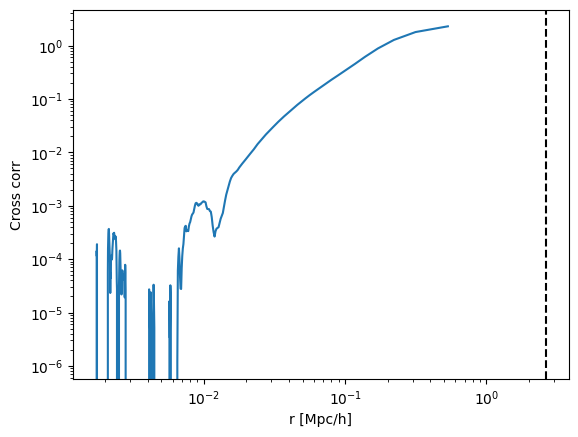

In [43]:
plt.figure()
plt.plot( 1 / r, xxi0, label="monopole")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Cross corr")
plt.axvline(2.65, color="k", ls="--", label="Nyquist")

plt.show()

In [87]:
with File("/mnt/extraspace/rstiskalek/csiborg2/fof_subhalo_tab_099.hdf5", 'r') as f:
    print(f["Group"].keys())
    x = f["Group/GroupMass"][:] * 1e10
    pos = f["Group/GroupPos"][:]

<KeysViewHDF5 ['GroupAscale', 'GroupFirstSub', 'GroupLen', 'GroupLenPrevMostBnd', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupOffsetType', 'GroupPos', 'GroupVel', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']>


In [92]:
x0 = np.ones(3) * 676.6 / 2

d = np.linalg.norm(pos - x0, axis=1)
m = d < 100

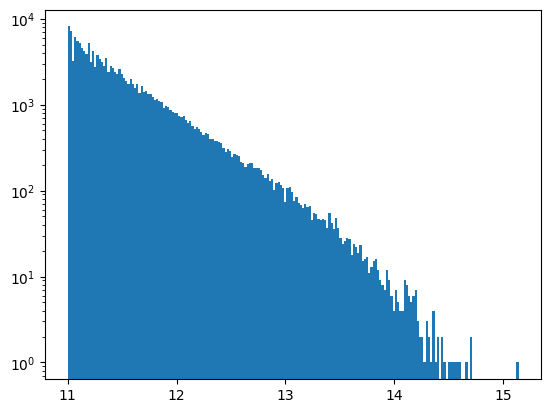

In [93]:
plt.figure()
plt.hist(np.log10(x[m]), bins="auto")

plt.yscale("log")

plt.show()

In [20]:
dx = (delta_new - delta_old.T) / delta_old.T

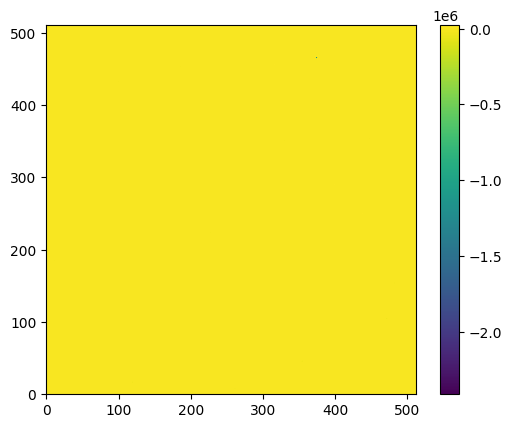

In [19]:
plt.figure()
plt.imshow(dx[:, :, 256], origin="lower")
plt.colorbar()

thetas = np.linspace(0, 2 * np.pi, 1000)
rad = 0.22 * 512
plt.plot(rad * np.cos(thetas) + 256, rad * np.sin(thetas) + 256, color="red", ls="--")


plt.show()

/tmp/ipykernel_24992/1715643559.py:6: RuntimeWarning: divide by zero encountered in log10
  axs[2].imshow(np.log10(np.abs(dx[:, :, 256])))


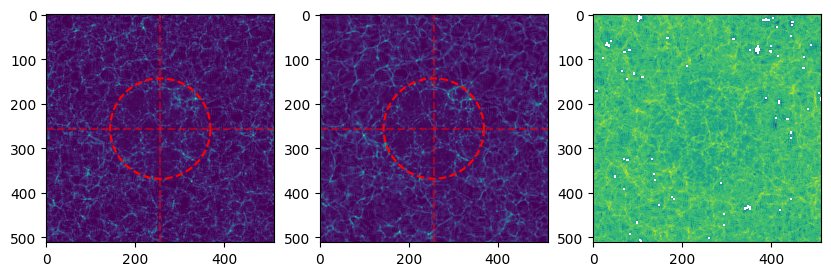

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))


axs[0].imshow(np.log10(delta_new[:, :, 256] + 2))
axs[1].imshow(np.log10((delta_old.T)[:, :, 256] + 2))
axs[2].imshow(np.log10(np.abs(dx[:, :, 256])))

thetas = np.linspace(0, 2 * np.pi, 1000)
rad = 0.22 * 512
for i in range(2):
    axs[i].plot(rad * np.cos(thetas) + 256, rad * np.sin(thetas) + 256, color="red", ls="--")
    axs[i].axvline(256, color="red", ls="--", alpha=0.5)
    axs[i].axhline(256, color="red", ls="--", alpha=0.5)
    
fig.show()

In [43]:
0.2 * 512

102.4

In [20]:
paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
cat = csiborgtools.read.CSiBORGCatalogue(7444, paths, "halofinder_catalogue", "FOF")

2023-11-23 11:17:00.672141:   opening `/mnt/extraspace/rstiskalek/CSiBORG/processed_output/parts_FOF_07444.hdf5`.


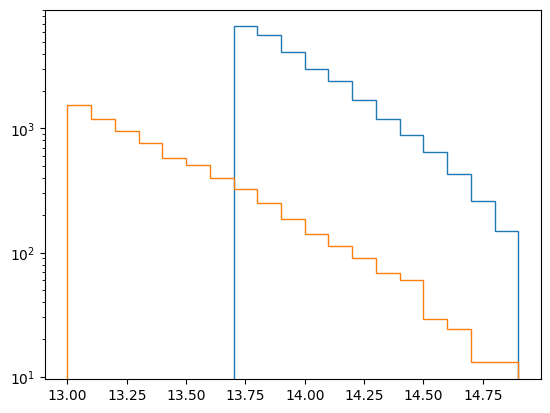

In [28]:
bins = np.arange(13, 15, 0.1)

plt.figure()
plt.hist(np.log10(mass), bins=bins, log=True, histtype="step")
plt.hist(np.log10(cat["totpartmass"]), bins=bins, log=True, histtype="step")



plt.show()

2023-11-23 11:16:53.499291:   opening `/mnt/extraspace/rstiskalek/CSiBORG/processed_output/parts_FOF_07444.hdf5`.


In [22]:
pos_old = cat["snapshot_final/pos"][:]

In [38]:
mass_old = cat["snapshot_final/mass"][:]

In [44]:
with File("/mnt/zfsusers/rstiskalek/gadget4/examples/V04_DM/output/snapshot_004.hdf5", 'r') as f:
    pos_new = f["PartType1/Coordinates"][:] / 677.7
    mass_new = np.ones(len(pos_new)) * 1e10 * 158.061
    # mass_new = f["PartType1/Mass"][:] * 1e10

In [90]:
box = csiborgtools.read.CSiBORGBox(951, 7444, paths)

field_generator = csiborgtools.field.DensityField(box, "PCS")

In [117]:
field_new = field_generator(pos_new, mass_new, 128)
field_old = field_generator(pos_old, mass_old, 128)

Loading particles for the density field:  97%|█████████▋| 30/31 [00:58<00:01,  1.97s/it]


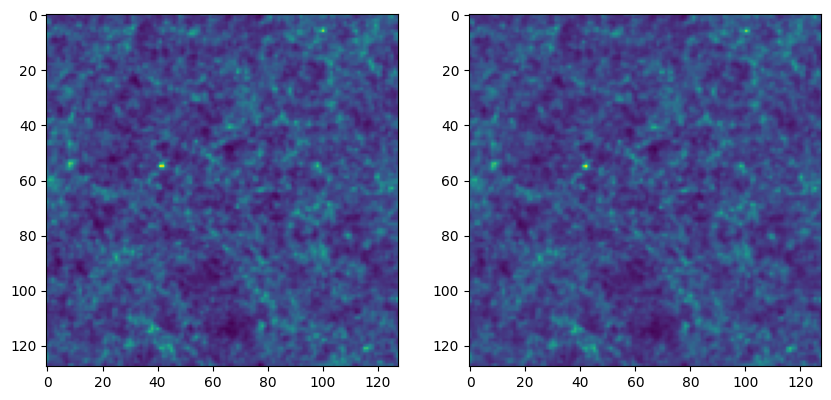

In [127]:
ax = 0
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.mean(field_new, axis=ax))
axs[1].imshow(np.mean(field_old.T, axis=ax))
# axs[1].imshow(np.mean(field_new, axis=ax) - np.mean(field_old.T, axis=ax))

plt.show()

In [119]:
delta_new = field_new / np.mean(field_new) - 1
delta_old = field_old / np.mean(field_old) - 1


knew, pnew = csiborgtools.field.power_spectrum(delta_new, box.boxsize, field_generator.MAS)
kold, pold = csiborgtools.field.power_spectrum(delta_old, box.boxsize, field_generator.MAS)


Computing power spectrum of the field...
Time to complete loop = 0.17
Time taken = 0.19 seconds

Computing power spectrum of the field...
Time to complete loop = 0.16
Time taken = 0.18 seconds


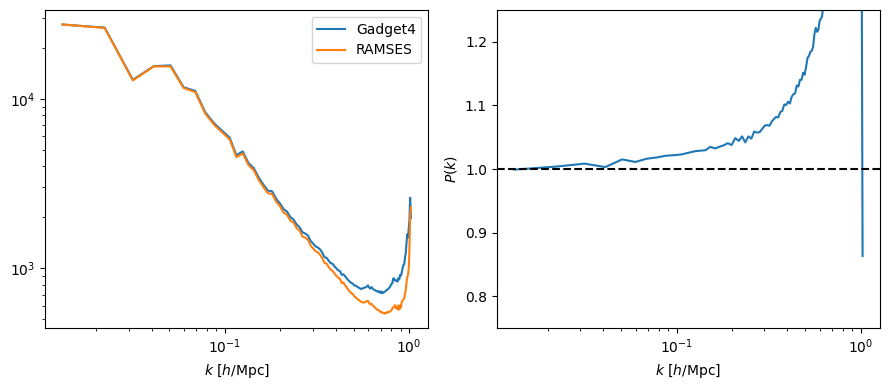

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].plot(knew, pnew, label="Gadget4")
axs[0].plot(kold, pold, label="RAMSES")
axs[0].set_yscale("log")
axs[0].set_xscale("log")

axs[1].plot(knew, pnew / pold)
axs[1].axhline(1, color="k", ls="--")
axs[1].set_xscale("log")
axs[1].set_ylim(0.75, 1.25)

axs

axs[0].set_xlabel(r"$k ~ [h / \mathrm{Mpc}]$")
axs[1].set_xlabel(r"$k ~ [h / \mathrm{Mpc}]$")
axs[1].set_ylabel(r"$P(k)$")
axs[0].legend()

fig.tight_layout()
# plt.savefig("../plots/powerspectrum_test_7444.png", dpi=300, bbox_inches="tight")

fig.show()

In [ ]:
csiborgtools.field.power_spectrum  